# Adaptive Signal Processing


#### Using the same given $d(n)$ and $x(n)$ speech signals and the same number of coefficients with $N=3$, implement the following Adaptive algorithms.

$$ $$
First, load the library, the signal, and compute the auto- and cross-correlation matrix and vector: $R$ and $p$ 

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import signal
from scipy import random
from scipy import io
import scipy.io.wavfile
import math

ratex, signal_x = io.wavfile.read('x.wav')
rated, signal_d = io.wavfile.read('d.wav')

x = (np.float64(signal_x))[0:400000]
d = (np.float64(signal_d))[0:400000]

corr_xx = np.zeros(3)
corr_xx[0] = np.correlate(x, x)/len(x)
corr_xx[1] = np.correlate(np.hstack((x,[0])), np.hstack(([0],x)))/len(x)
corr_xx[2] = np.correlate(np.hstack((x,[0,0])), np.hstack(([0,0],x)))/len(x)

corr_xd = np.zeros(3)
corr_xd[0] = np.correlate(x, d)/len(d)
corr_xd[1] = np.correlate(np.hstack(([0],x)), np.hstack((d,[0])))/len(d)
corr_xd[2] = np.correlate(np.hstack(([0,0],x)), np.hstack((d,[0,0])))/len(d)

power_d = np.correlate(d,d)/len(d)
power_x = np.correlate(x,x)/len(x)

R = np.matrix(scipy.linalg.toeplitz(corr_xx[0:3].conj(), corr_xx[0:3]))
p = np.matrix(corr_xd).T

corr_sz = np.correlate(x,x, mode='valid')/len(x)

Steepest descent and Newton method, as we did previously.

In [2]:
### Steepest Descent ###

w_sd =[]
w_sd.append(np.zeros((3,1)))
w_sd_t = 0
sigma_x = float(np.correlate(x,x))
mu_sd = np.float(0.25/(3 * power_x))

e_sd = []

for i in range(0,len(x)):
    w_sd_t = w_sd[i] - 2 * mu_sd * (R * w_sd[i] - p)
    w_sd.append(w_sd_t)

    if i == 0:
        X_t = np.matrix([[x[i]], [0], [0]])
    elif i == 1:
        X_t = np.matrix([[x[i]], [x[i-1]], [0]])
    else:
        X_t = np.matrix([[x[i]], [x[i-1]], [x[i-2]]])
        
    e_sd.append(d[i] - np.matmul(w_sd[i].T, X_t)[0,0])


### Newton ###

w_newton =[]
w_newton.append(np.zeros((3,1)))
mu_newton = 0.25

e_newton = []

for i in range(0,len(x)):
    w_newton_t = w_newton[i] - mu_newton * np.linalg.inv(R) * (R * w_newton[i] - p)
    w_newton.append(w_newton_t)

    if i == 0:
        X_t = np.matrix([[x[i]], [0], [0]])
    elif i == 1:
        X_t = np.matrix([[x[i]], [x[i-1]], [0]])
    else:
        X_t = np.matrix([[x[i]], [x[i-1]], [x[i-2]]])
        
    e_newton.append(d[i] - np.matmul(w_newton[i].T, X_t)[0,0])

E_sd = (np.abs(e_sd))**2
D_sd = (np.abs(d))**2
E_newton = (np.abs(e_newton))**2
D_newton = (np.abs(d))**2

h_smooth = []
a_smooth = []
for j in range(0,1001):
    h_smooth.append(1/1000)
    a_smooth.append(1)

Es_sd = np.convolve(h_smooth, E_sd)
Ds_sd = np.convolve(h_smooth, D_sd)
Es_newton = np.convolve(h_smooth, E_newton)
Ds_newton = np.convolve(h_smooth, D_newton)

learning_curve_sd = 10 * np.log10(Es_sd/Ds_sd)
learning_curve_newton = 10 * np.log10(Es_newton/Ds_newton)

e_sd = np.int16(e_sd)
e_newton = np.int16(e_newton)

io.wavfile.write('1_Steepest Descent.wav', ratex, e_sd)
io.wavfile.write('2_Newton.wav', ratex, e_newton)

Least-mean-square algorithm. Here the coefficients will be updated for every sample of the given data, instead of the iteration steps. where $e(n)$ is the "a priori" error signal, i.e., obtained from the most recent data $x(n)$ and $d(n)$, but using the coefficients $w(n)$ before they are updated with the steepest descent update equation. $$ $$
This results in the following very simple “least mean-squares” (LMS) stochastic gradient algorithm, which doesn't require either $R$ or $p$. $$ $$
Under some assumptions, in the textbook an upper bound for the range of $\mu$ leading to convergence is found to be: $$ $$
$$ 0\leq{\mu}\leq{\frac{2}{Tr[R]}}=\frac{2}{N\sigma_x^2}$$
$$ $$
The range of $\mu$ values leading to convergence is then approximately $0\leq{\mu}\leq{2}$.
$$ $$
In order to achieve a better noise cancellation paradim, in this case, the hyperparameters are tuned through many experiments. A better parameters are used for better quality of the filtered signals. Thus $\mu=0.05/(3*3*\phi_0^2)$ for LMS and $\mu=0.02$ for Normalized LMS.

In [3]:
### LMS & NLMS ###

mu = 0.05/(3 * 3 * corr_sz[0])
w_lms =[]
w_lms.append(np.zeros((3,1)))
e_lms = []

mu_nlms = 0.02  # step size
kesai = 200
w_nlms =[]
w_nlms.append(np.zeros((3,1)))
e_nlms = []

for i in range(0,len(x)):
    if i == 0:
        X_t = np.matrix([[x[i]],[0],[0]])
    elif i == 1:
        X_t = np.matrix([[x[i]],[x[i-1]],[0]])
    else:
        X_t = np.matrix([[x[i]],[x[i-1]],[x[i-2]]])
        
    e_lms.append(signal_d[i] - np.matmul(w_lms[i].T, X_t)[0,0])
    w_lms.append(w_lms[i] + mu * X_t * e_lms[i])
    
    e_nlms.append(signal_d[i] - np.matmul(w_nlms[i].T, X_t)[0,0])
    w_nlms.append(w_nlms[i] + mu_nlms * (1/(X_t.H*X_t+kesai))[0,0] * X_t * e_nlms[i])
    
E_lms = (np.abs(e_lms))**2
E_nlms = (np.abs(e_nlms))**2

D_lms = (np.abs(d))**2

h_smooth = []
a_smooth = []
for j in range(0,1001):
    h_smooth.append(1/1000)
    a_smooth.append(1)
    
Es_lms = np.convolve(h_smooth, E_lms)
Es_nlms = np.convolve(h_smooth, E_nlms)

Ds_lms = np.convolve(h_smooth, D_lms)

learning_curve_lms = 10 * np.log10(Es_lms/Ds_lms)
learning_curve_nlms = 10 * np.log10(Es_nlms/Ds_lms)

e_lms = np.int16(e_lms)
e_nlms = np.int16(e_nlms)

io.wavfile.write('3_LMS.wav', ratex, e_sd)
io.wavfile.write('4_Normalized LMS.wav', ratex, e_newton)

It is also possible to combine the “instantaneous” or stochastic estimate with a Newton update equation, resulting in the Newton-LMS form (which however requires knowledge of cross-correlation matrix $R$)
$$ $$
The resulting range of step size for convergence of the Newton-LMS can be estimated as 
$$ $$
$$0\leq{\mu}\leq{\frac{2}{3N}}$$
$$ $$
but this range can be considered strict and sometimes a larger range can be used:
$$ $$
$$0\leq{\mu}\leq{\frac{2}{N}}$$
$$ $$
The $\mu=0.05/(3*3)$ was tuned in this case.

In [4]:
### Newton LMS ###

w_Nlms =[]
w_Nlms.append(np.zeros((3,1)))
e_Nlms = []

R_inverse=np.linalg.inv(R)

mu_nt_lms = 0.05/(3*3)
w_nt_lms =[]
w_nt_lms.append(np.zeros((3,1)))
e_nt_lms = []

for i in range(0,len(x)):
    if i == 0:
        X_t = np.matrix([[x[i]],[0],[0]])
    elif i == 1:
        X_t = np.matrix([[x[i]],[x[i-1]],[0]])
    else:
        X_t = np.matrix([[x[i]],[x[i-1]],[x[i-2]]])

    e_nt_lms.append(signal_d[i] - np.matmul(w_nt_lms[i].T, X_t)[0,0])
    w_nt_lms.append(w_nt_lms[i] + mu_nt_lms * R_inverse * X_t * e_nt_lms[i])

E_nt_lms = (np.abs(e_nt_lms))**2
D_nt_lms = (np.abs(d))**2

h_smooth = []
a_smooth = []
for j in range(0,1001):
    h_smooth.append(1/1000)
    a_smooth.append(1)
    
Es_nt_lms = np.convolve(h_smooth, E_nt_lms)
Ds_nt_lms = np.convolve(h_smooth, D_nt_lms)

learning_curve_nt_lms = 10 * np.log10(Es_nt_lms/Ds_nt_lms)

e_nt_lms = np.int16(e_nt_lms)

io.wavfile.write('5_Newton LMS.wav', ratex, e_nt_lms)

This constraint means that $w(n+1)$ must be the exact solution for the last $M$ sets of $x(n)$, $d(n)$ data. In practice, a more general form of the Affine Projection (AP) algorithm allows to use a step size:
$$ $$
$$ \mu(n)=\mu({X^T}(n)X(n))^{-1} $$
$$ $$
where the $\mu$ is a positive value which may differ from 1.0 and includes a regularization factor (diagonal loading).
$$ $$
In this affine projection case, $\mu$ was tuned and chosen as 0.002, while $\psi$ was 100.

In [5]:
### Affine Projection ###

mu_ap = 0.002
eta = 100

w_ap =[]
w_ap.append(np.zeros((3,1)))
e_ap = []

for i in range(0,len(x)):
    if i == 0:
        X_t = np.matrix([[x[i], 0, 0], 
                         [0, 0, 0], 
                         [0, 0, 0]])
        d_ap = np.matrix([d[i],0,0])
    elif i == 1:
        X_t = np.matrix([[x[i], x[i-1], 0], 
                         [x[i-1], 0, 0], 
                         [0, 0, 0]])
        d_ap = np.matrix([d[i],d[i-1],0])
    elif i == 2:
        X_t = np.matrix([[x[i], x[i-1], x[i-2]], 
                         [x[i-1], x[i-2], 0], 
                         [x[i-2], 0, 0]])
        d_ap = np.matrix([d[i],d[i-1],d[i-2]])
    else:
        X_t = np.matrix([[x[i], x[i-1], x[i-2]], 
                         [x[i-1], x[i-2], x[i-3]], 
                         [x[i-2], x[i-3], x[i-4]]])
        d_ap = np.matrix([d[i],d[i-1],d[i-2]]) 
        
    error_ap = d_ap - np.matrix(w_ap[i]).T * X_t
    w_ap.append(w_ap[i] + mu_ap * X_t * np.linalg.inv(X_t.H * X_t + eta * np.identity(3)) * error_ap.H)
    e_ap.append(signal_d[i] - np.matmul(w_ap[i].T, X_t)[0,0])
    
E_ap = (np.abs(e_ap))**2
D_ap = (np.abs(d))**2

h_smooth = []
a_smooth = []

for j in range(0,1001):
    h_smooth.append(1/1000)
    a_smooth.append(1)
    
Es_ap = np.convolve(h_smooth, E_ap)
Ds_ap = np.convolve(h_smooth, D_ap)

learning_curve_ap = 10 * np.log10(Es_ap/Ds_ap)

e_ap = np.int16(e_ap)
io.wavfile.write('6_Affine Projection.wav', ratex, e_ap)

Solving for $\hat{w}ˆ(n)$ in the previous LS implementation can be expensive (approx. $(N^3)/6+N^2$ multiplies or $7{N^2}+N^2$ multiplies if time series). Alternative implementations can be developed in order to reduce complexity.
$$ $$
where $\hat{e}_{n-1}(n)=d(n)-{\hat{w}}^H)(n-1)x(n)$ is the “a priori” error signal, obtained from the most recent data $x(n)$ and $d(n)$.
$$ $$
but using the coefficients $\hat(w)(n-1)$ before they are updated with the above update equation. The error signal obtained once the $\hat(w)(n)$ coefficients have been updated is the “a posteriori” error signal, ${\hat(e)_n}(n)=d(n)-{\hat(w)^H}(n)x(n)$, which corresponds to the error signal in the initial formulation of the least-squares problem. 
$$ $$
In this RLS case, $\delta$ was tuned and chosen as 0.001, while $\lambda$ was 0.99 in this case.

In [6]:
### RLS ###

w_RLS =[]
w_RLS.append(np.zeros((3,1)))
e_RLS = []
delta = 0.001
lammda = 0.99
P = (1/delta) * np.identity(3)
e_RLS = []

for i in range(0,len(x)):
    if i == 0:
        u = np.matrix([[x[i]],[0],[0]])
    elif i == 1:
        u = np.matrix([[x[i]],[x[i-1]],[0]])
    else:
        u = np.matrix([[x[i]],[x[i-1]],[x[i-2]]])
        
    g = P * u / ( lammda + u.T * P * u )
    e_rls = d[i] - np.matmul(w_RLS[i].T, u)[0,0]
    e_RLS.append(e_rls)
    w_RLS.append(w_RLS[i] + g * e_RLS[i])
    P = (1/lammda) * (P - g * u.T * P)
    
E_ap = (np.abs(e_RLS))**2
D_ap = (np.abs(d))**2

h_smooth = []
a_smooth = []

for j in range(0,1001):
    h_smooth.append(1/1000)
    a_smooth.append(1)
    
Es_ap = np.convolve(h_smooth, E_ap)
Ds_ap = np.convolve(h_smooth, D_ap)

learning_curve_RLS = 10 * np.log10(Es_ap/Ds_ap)

e_RLS = np.int16(e_RLS)
io.wavfile.write('7_RLS.wav', ratex, e_RLS)

Simulation results: the demonstration of the performance of each adaptive algorithms.

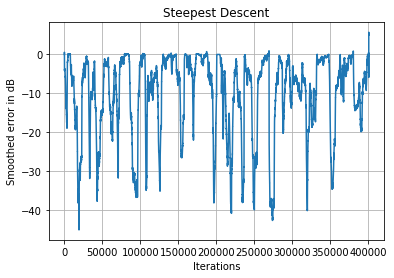

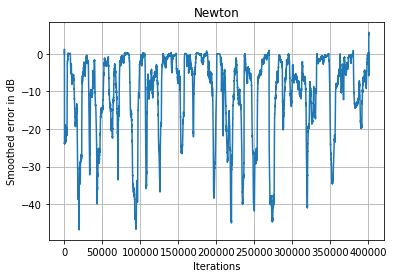

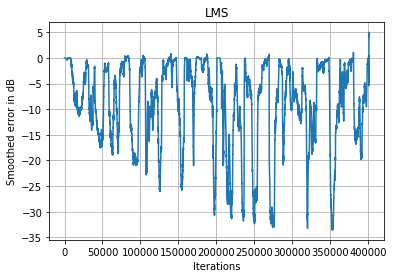

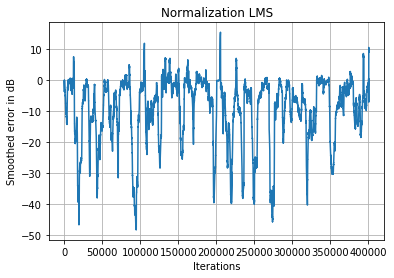

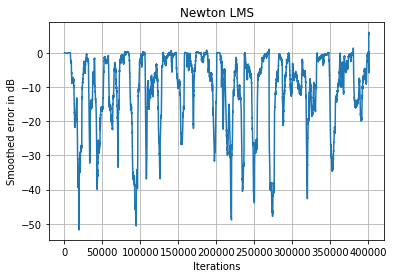

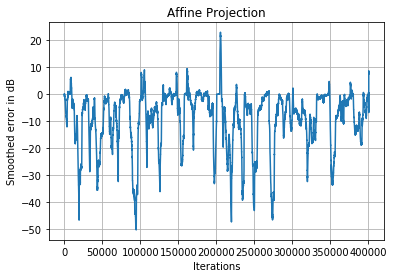

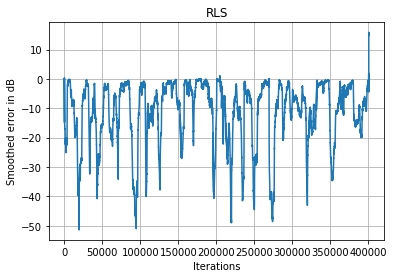

In [7]:
plt.figure()
plt.plot(learning_curve_sd)
plt.title('Steepest Descent')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

plt.figure()
plt.plot(learning_curve_newton)
plt.title('Newton')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

plt.figure()
plt.plot(learning_curve_lms)
plt.title('LMS')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

plt.figure()
plt.plot(learning_curve_nlms)
plt.title('Normalization LMS')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

plt.figure()
plt.plot(learning_curve_nt_lms)
plt.title('Newton LMS')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

plt.figure()
plt.plot(learning_curve_ap)
plt.title('Affine Projection')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

plt.figure()
plt.plot(learning_curve_RLS)
plt.title('RLS')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Smoothed error in dB')
plt.show()

### Conclusion:

After tunning the hyperparameters for each adaptive algorithm, the noise cancelling paradims are perform satisfied effects. LMS converged a little bit slower since it is used every single data to estimated gradient (biased), which suffers from the noise, but anyway this algorithm sacrified the local computation steps to get a global learning efficiency. <br>

Normalizated LMS performed satisfied as well, but it turns to be non-stable from the error curve where the error jumps to positive at some certain moment. This situation happened in Affine projection as well (Affine projection is the special case of Normalized LMS when $M=1$). One of the reason can be that these algorithms tends to deal with the stationary signal, but for the speech signals used in our assignment is not that sationary sometiom.<br>

Steepest descent is a first order Tylor expansion in mathmatics, and it used the gradient estimation from the correlation matrix. Similiar to Newton, but it is second order method. Newton converges fast, but it will cost time when compute the inverse of the Hessian matrix, but in our case we can get the unbiased estimation of the Hessian from where it started. <br>

Newton LMS and RLS performs satisfied as well, but there is some "sparks" noise in the reconstructed signals. Definitly the hyperparameters should be carefully chosen for each algorithm since those parameter really affects the prtformance.<br>